In [15]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Lasso
# additional libraries for profiling, (also need to install sweetviz, ipywidgets, setuptools, xlrd in the virtual environment)
import sweetviz as sv
import datetime

Dataset: Credit Card Default Prediction

This project is aimed at predicting the case of customers default payments in Taiwan.

Attribute Information: 
This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [ ]:
# Run profiling and load dataset

# IMPORTANT NOTE - To avoid errors when loading the original dataset in sweetviz, the first header row was removed and file used is 'default_of_credit_card_clients_nx.xls'
# sweetviz
import sweetviz as sv
import pandas as pd
import numpy as np
import datetime

if not hasattr(np, 'VisibleDeprecationWarning'):
    np.VisibleDeprecationWarning = DeprecationWarning

credit_card_def_df = pd.read_excel('data/default_of_credit_card_clients_nx.xls')

from datetime import datetime

report =sv.analyze(credit_card_def_df)
report.show_html('Default_of_credit_cards_sweetviz.html')


                                             |          | [  0%]   00:00 -> (? left)

Report Default_of_credit_cards_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Findings from Sweetviz and analysis of the dataset features

- The dataset contains 30000 records with no missing values
- The column marriage should be renamed in marital status as there are 4 possible values not 3 as mentionned on Kaggle
- Payment delay column
Scale for PAY_0 to PAY_6 : (-2 = No consumption, -1 = paid in full, 0 = use of revolving credit (paid minimum only), 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above)

PAY_0: Repayment status in September, 2005 (scale same as above)
PAY_2: Repayment status in August, 2005 (scale same as above)
PAY_3: Repayment status in July, 2005 (scale same as above)
PAY_4: Repayment status in June, 2005 (scale same as above)
PAY_5: Repayment status in May, 2005 (scale same as above)
PAY_6: Repayment status in April, 2005 (scale same as above)

- Bill statement amount
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

- Previous payement amount
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

- default.payment.next.month: Default payment (1=yes, 0=no) 






In [7]:
# Load and copy the data before cleaning

credit_card_def_df = pd.read_excel('data/default_of_credit_card_clients_nx.xls')
original_credit_card_def_df = credit_card_def_df.copy()

# Check for colums and dtypes
credit_card_def_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [8]:
credit_card_def_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [12]:
# Rename columns
credit_card_def_df.rename(columns={'MARRIAGE': 'MARITAL STATUS'}, inplace=True)

credit_card_def_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARITAL STATUS,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [13]:
# Check for missing values
credit_card_def_df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARITAL STATUS                0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [19]:
# Create feature and target arrays
X = credit_card_def_df.drop("default payment next month", axis=1).values
y = credit_card_def_df["default payment next month"].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Instantiate the model
logreg = LogisticRegression(max_iter=1000, solver='liblinear')

# Fit the model
logreg.fit(X_train, y_train)

# Predict probabilities
y_pred_probs = logreg.predict_proba(X_test)[:,1] # ,0 = samples belonging to class 0, :,1 = samples belonging to class 1
y_pred_logreg = logreg.predict(X_test)

print(y_pred_probs[:5])

[0.18304531 0.30815206 0.02689155 0.38631676 0.35928121]


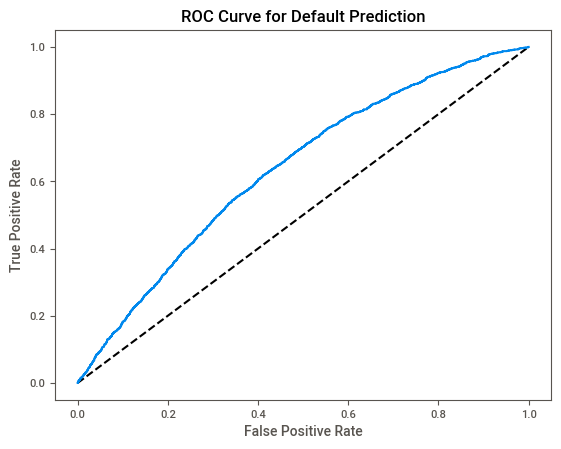

In [20]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Default Prediction')
plt.show()

In [21]:
# Compute the AUC
auc = roc_auc_score(y_test, y_pred_probs)
print("AUC: {}".format(auc))

AUC: 0.6360496968846613


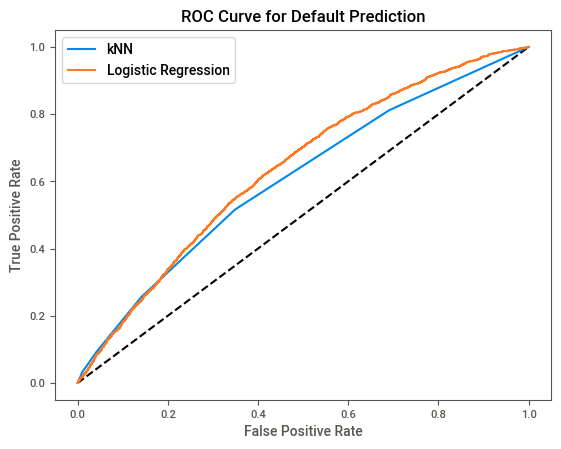

AUC for kNN: 0.6066288883511255


In [23]:
# Predict probabilities
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the model to the training data
knn.fit(X_train, y_train)

y_pred_probs_knn = knn.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_probs_knn)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr for kNN
plt.plot(fpr_knn, tpr_knn, label='kNN')

# Plot tpr against fpr for Logistic Regression
plt.plot(fpr, tpr, label='Logistic Regression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Default Prediction')
plt.legend()
plt.show()

# Calculate the area under the ROC curve (AUC) for kNN
auc_knn = roc_auc_score(y_test, y_pred_probs_knn)
print("AUC for kNN: {}".format(auc_knn))

In [28]:
# Calculate the confusion matrix
print(confusion_matrix(y_test, y_pred_logreg))
conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_logreg), index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print(conf_matrix_df)

# Calculate the classification report
print(classification_report(y_test, y_pred_logreg))

[[7009    0]
 [1991    0]]
                 Predicted Negative  Predicted Positive
Actual Negative                7009                   0
Actual Positive                1991                   0
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      7009
           1       0.00      0.00      0.00      1991

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.61      0.78      0.68      9000



c:\Users\abarboni\Documents\Syntra\Danny\ve-regression\data_science_cases\reg\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abarboni\Documents\Syntra\Danny\ve-regression\data_science_cases\reg\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abarboni\Documents\Syntra\Danny\ve-regression\data_science_cases\reg\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_